In [26]:
# import the necessary packages

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


## Pre-processing
We will try to normalize dataset with ZScale and Min-Max approached to perform DBSCAN, then pick the best. But first, let's see if there is any outlier to drop.

<Axes: >

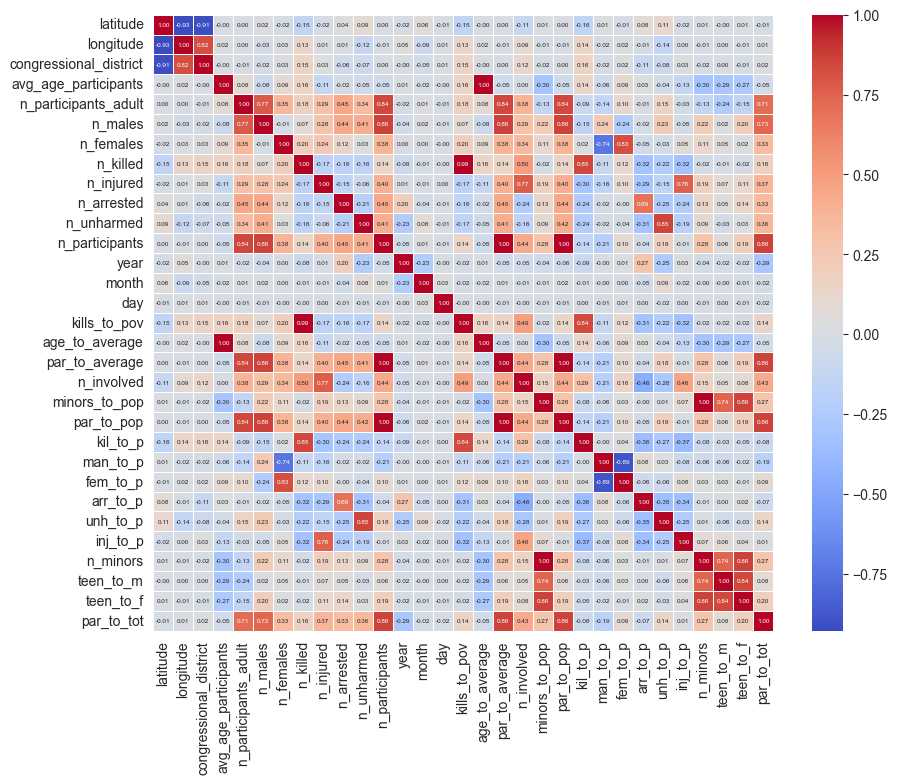

In [27]:
df = pd.read_csv('../data/new_incidents.csv')

standard = StandardScaler()
minmax = MinMaxScaler()

#pick the California data
df = df[df['state'] == 'California']

# plot correlation matrix to see if there is any feature to drop
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include='number').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={"size": 4.6})

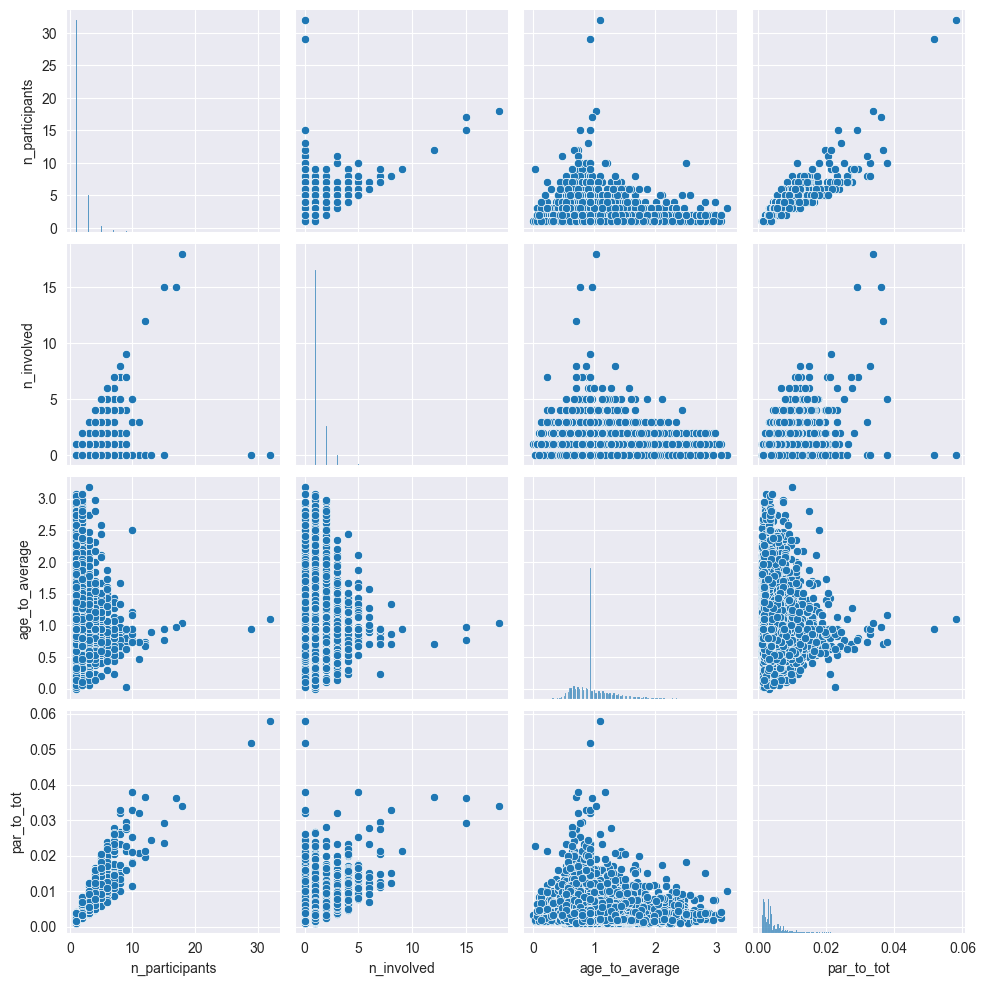

In [28]:
# select only the features that we want to use
df = df.dropna(subset=['n_participants', 'n_involved', 'age_to_average', 'par_to_tot'])
new_df = df[['n_participants', 'n_involved', 'age_to_average', 'par_to_tot']]
sns.pairplot(new_df)

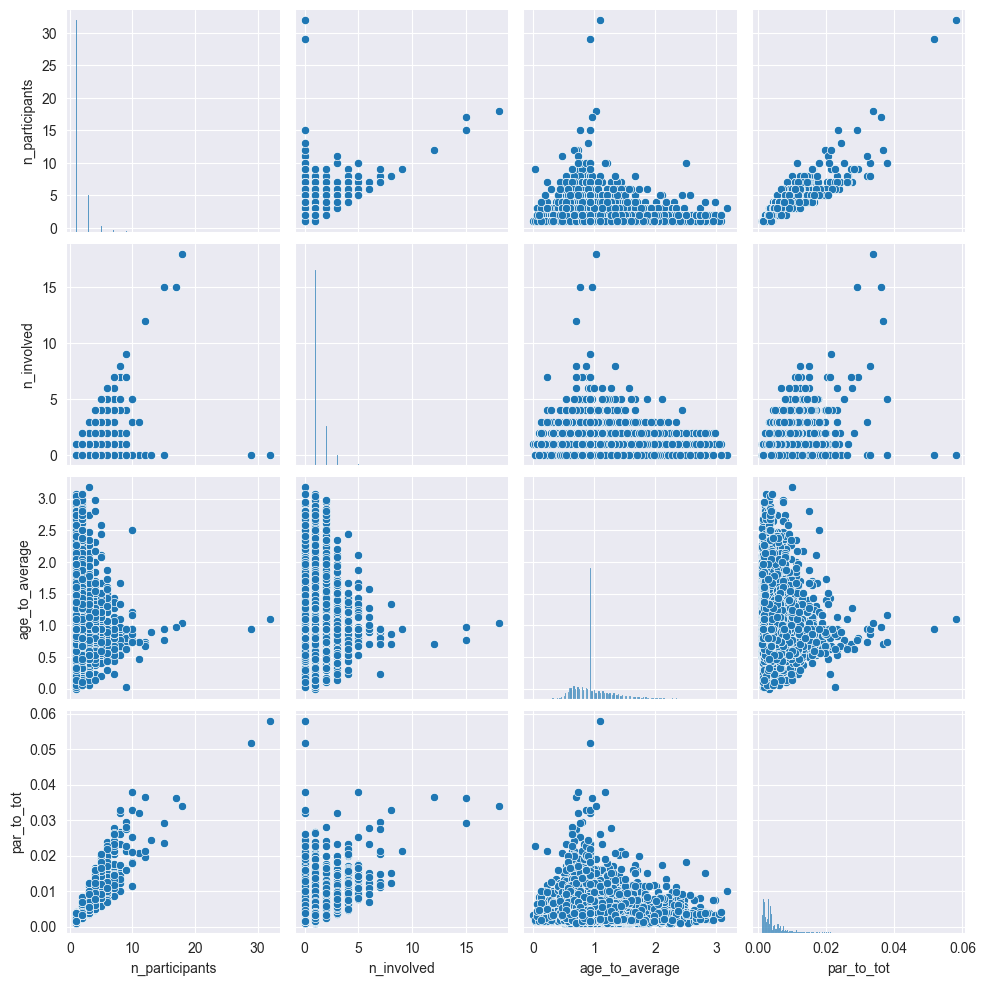

In [29]:
# remove the outlier in california's participants
df = df[(df['n_participants'] < 20) | (df['n_involved'] < 10)]

new_df = df[['n_participants', 'n_involved', 'age_to_average', 'par_to_tot']]
sns.pairplot(new_df)

In [30]:
# scale the data
ss_scaled = standard.fit_transform(new_df)
mm_scaled = minmax.fit_transform(new_df)

# DBSCAN algorithm
We perform the density-based clustering using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm.
It has only two parameters...

- eps: The maximum distance between two samples for them to be considered as in the same neighborhood.
- min_samples: the minimum number of points needed to create a cluster.

... and one output:
- cluster labels for each point in the dataset. Noisy samples are given the label -1.

We can find the best parameters for the DBSCAN algorithm by using the silhouette score. The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a higher value indicates that the object is better matched to its own cluster and worse matched to neighboring clusters.

To find a good range of values for eps, we first plot a graph of the distance to the nearest neighbor of each point, sorted by distance. We then look for a point where the distance between points jumps up sharply, and use that as a value for eps. This is known as the knee method.

In [31]:
from scipy.spatial.distance import pdist, squareform
import tqdm


def calc_k_nn_dist_graph(X, ub=0., lb=0.):
    k_list = [3, 5, 9, 15]

    dist = pdist(X, 'euclidean')
    dist = squareform(dist)

    for k in k_list:
        kth_distances = []
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        plt.figure(figsize=(8, 6))
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.grid()
        plt.axhline(ub)
        plt.axhline(lb)
        plt.title('Graph of distance from %sth nearest neighbor' % k)
        plt.show()


In [32]:
# values of min_samples to try
min_samples = range(3, 25, 3)

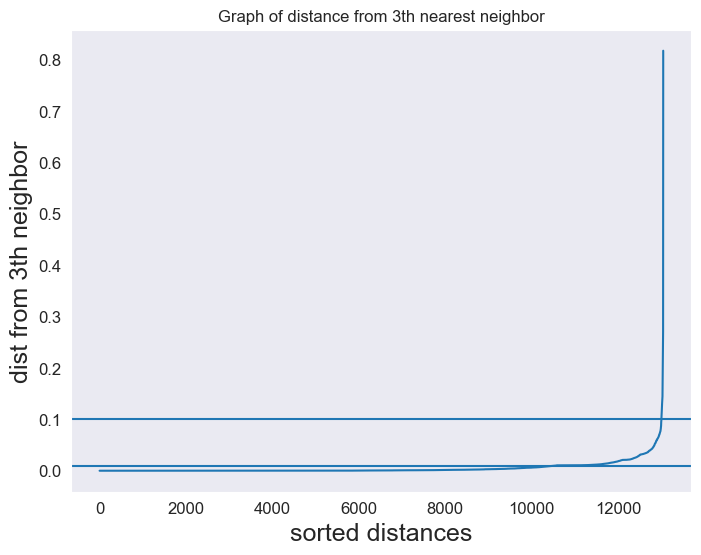

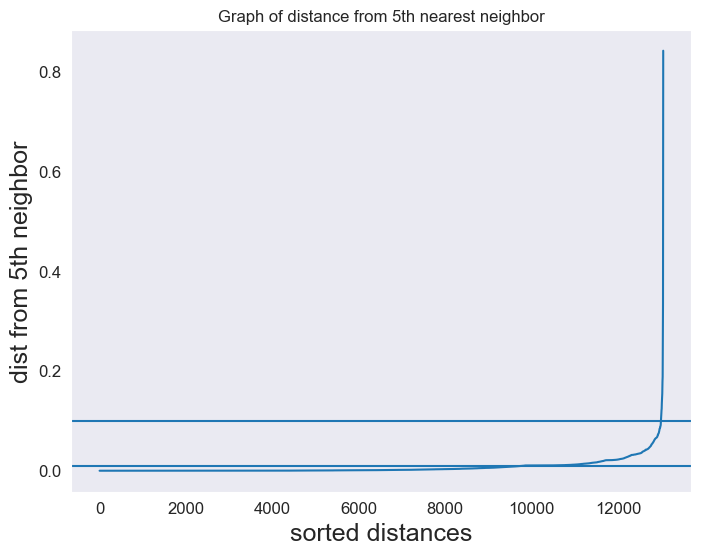

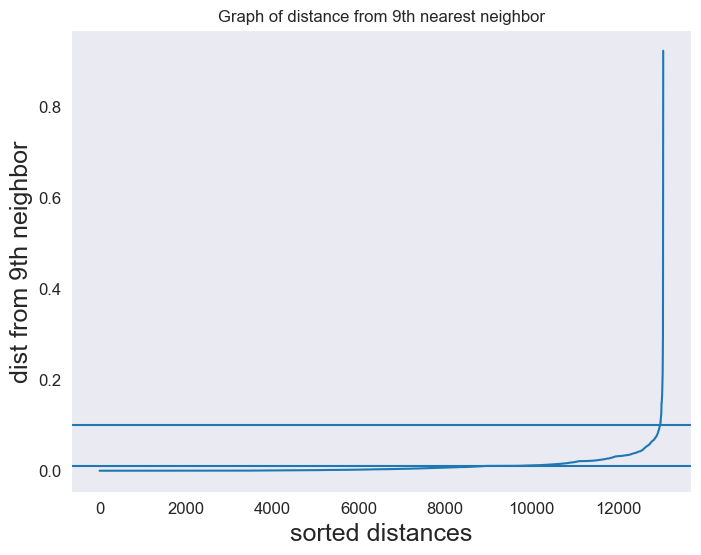

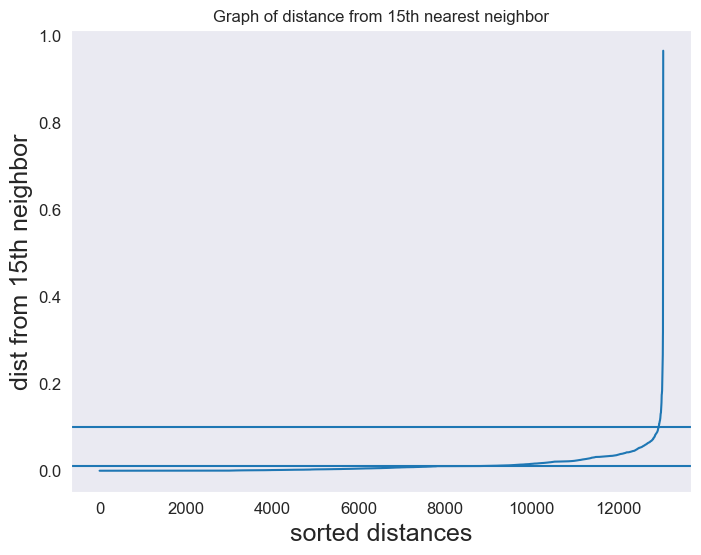

In [33]:
calc_k_nn_dist_graph(mm_scaled, 0.01, 0.1)

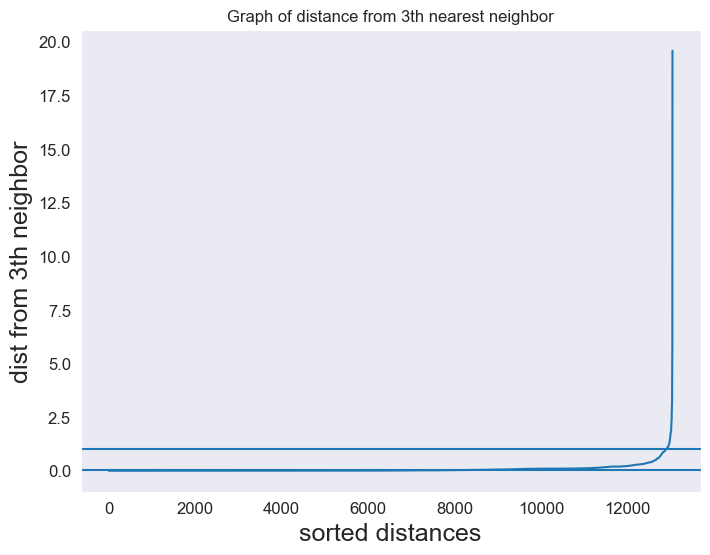

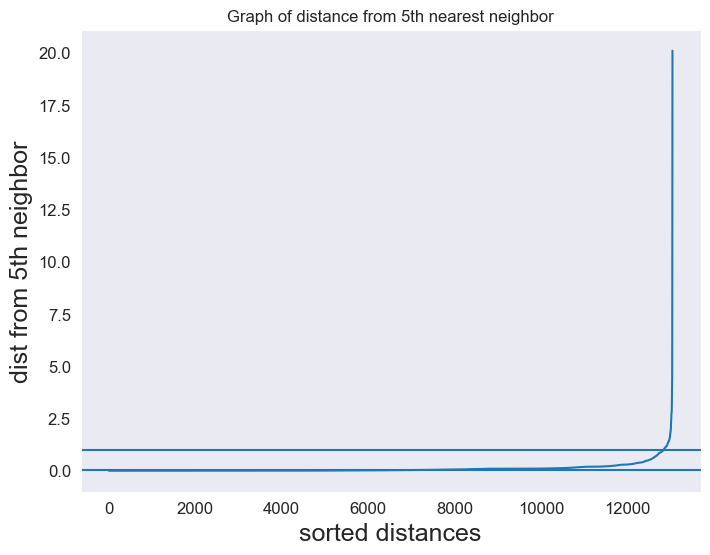

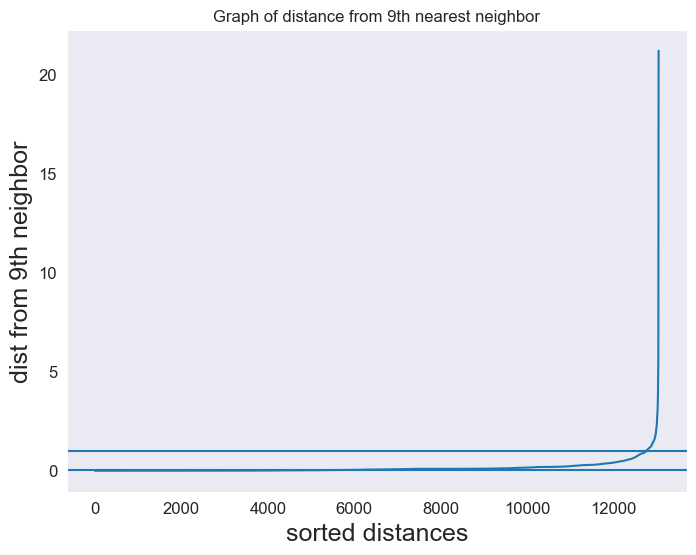

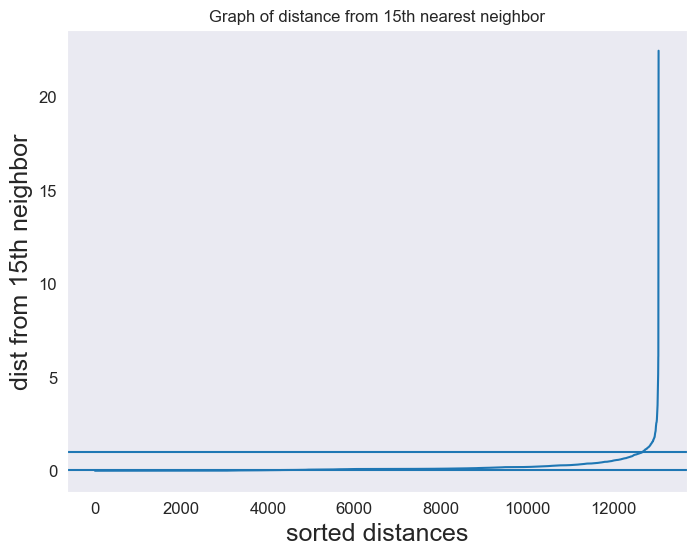

In [34]:
#repeat the same for standard scaled data
calc_k_nn_dist_graph(ss_scaled, 0.05, 1)

In [35]:
def print_best_params(silhouette_scores, parameter_combinations):
    best_score_index = np.argmax(silhouette_scores)  # Get the index of the maximum silhouette score
    best_params = parameter_combinations[best_score_index]  # Retrieve parameters corresponding to the best score

    best_eps, best_min_samples, n_clusters = best_params  # Unpack the best parameters

    best_score = silhouette_scores[best_score_index]  # Get the best silhouette score

    # Print the best silhouette score and corresponding parameters
    print(f"Best Silhouette Score: {best_score}")
    print(f"Best Parameters - eps: {best_eps}, min_samples: {best_min_samples}", f"Number of clusters: {n_clusters}")
    return best_eps, best_min_samples

# MinMax Scaling Test

In [36]:
mm_eps_values = np.arange(0.05, 0.105, 0.005)

In [37]:
# test the best parameters for the DBSCAN algorithm
silhouette_scores = []
parameter_combinations = []

best_score = -1  # Initialize best silhouette score
best_params = {'eps': None, 'min_samples': None, 'n_clusters': None}
for eps in mm_eps_values:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(mm_scaled)

        unique_labels = np.unique(labels)
        if len(unique_labels) < 3: continue # skip if there is only one cluster and noise
        silhouette = silhouette_score(mm_scaled, labels)
        print(
            f"Number of clusters: {len(unique_labels)}, eps: {eps}, min_samples: {min_sample} , Silhouette score: {silhouette}")
        silhouette_scores.append(silhouette)
        parameter_combinations.append((eps, min_sample, len(unique_labels)))

# Plotting the results
silhouette_scores = np.array(silhouette_scores)
parameter_combinations = np.array(parameter_combinations)


Number of clusters: 20, eps: 0.05, min_samples: 3 , Silhouette score: 0.05833248257954336
Number of clusters: 10, eps: 0.05, min_samples: 6 , Silhouette score: 0.09002483846846739
Number of clusters: 7, eps: 0.05, min_samples: 9 , Silhouette score: 0.060698987873422844
Number of clusters: 7, eps: 0.05, min_samples: 12 , Silhouette score: 0.09123601021960377
Number of clusters: 7, eps: 0.05, min_samples: 15 , Silhouette score: 0.09497986818133328
Number of clusters: 6, eps: 0.05, min_samples: 18 , Silhouette score: 0.10415034594028355
Number of clusters: 6, eps: 0.05, min_samples: 21 , Silhouette score: 0.10526919853555679
Number of clusters: 6, eps: 0.05, min_samples: 24 , Silhouette score: 0.10441433588805339
Number of clusters: 16, eps: 0.055, min_samples: 3 , Silhouette score: 0.07157306121225218
Number of clusters: 7, eps: 0.055, min_samples: 6 , Silhouette score: 0.1056483188905094
Number of clusters: 6, eps: 0.055, min_samples: 9 , Silhouette score: 0.10598150533492982
Number of 

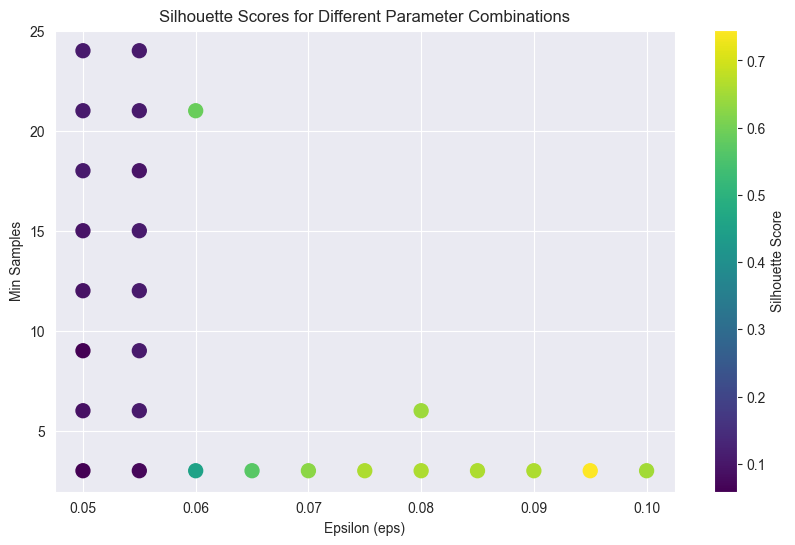

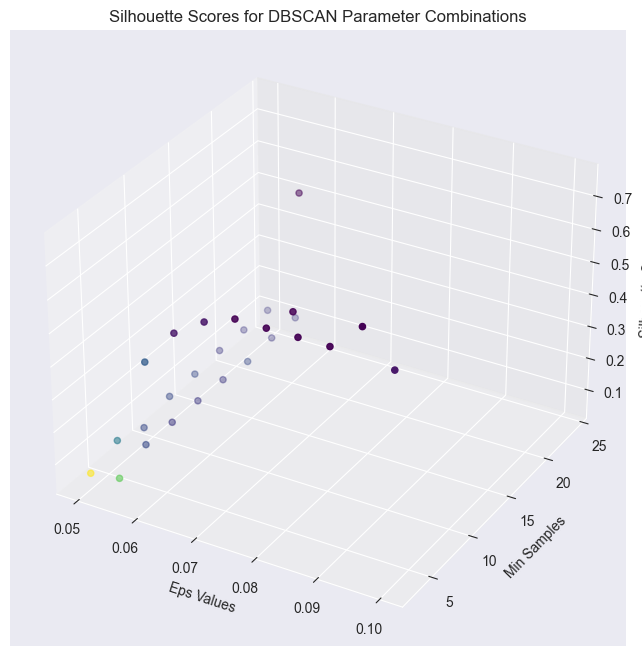

Best Silhouette Score: 0.7457328767434341
Best Parameters - eps: 0.09499999999999997, min_samples: 3.0 Number of clusters: 3.0


In [38]:
eps_values = parameter_combinations[:, 0]
min_samples_values = parameter_combinations[:, 1]
n_clusters = parameter_combinations[:, 2]

plt.figure(figsize=(10, 6))
plt.scatter(eps_values, min_samples_values, c=silhouette_scores, cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Min Samples')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(eps_values, min_samples_values, silhouette_scores, c=n_clusters, cmap='viridis')
ax.set_xlabel('Eps Values')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('Silhouette Scores for DBSCAN Parameter Combinations')

plt.show()

best_eps, best_min_samples = print_best_params(silhouette_scores, parameter_combinations)

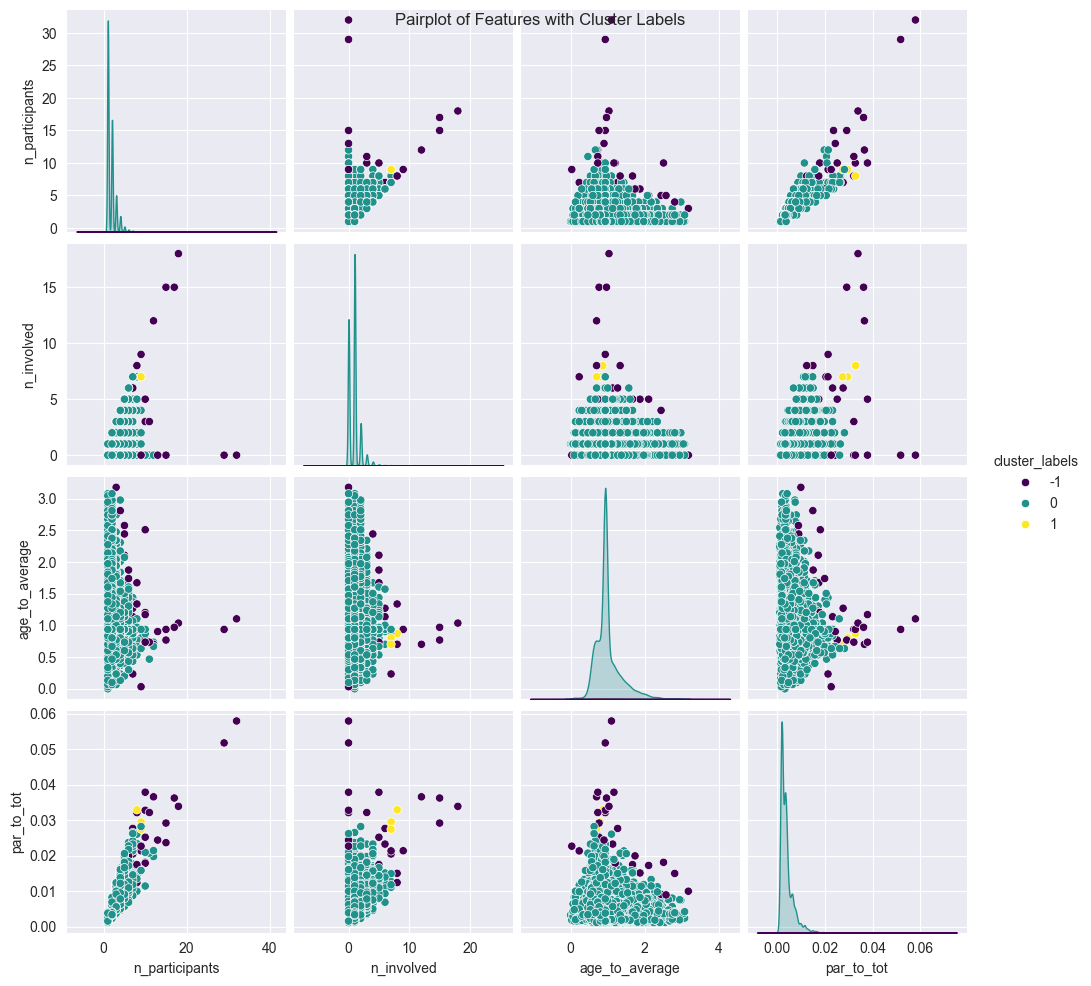

cluster_labels
 0    13007
-1       32
 1        3
Name: count, dtype: int64

In [39]:
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
cluster_labels = dbscan.fit_predict(mm_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()

0.5898309990264528


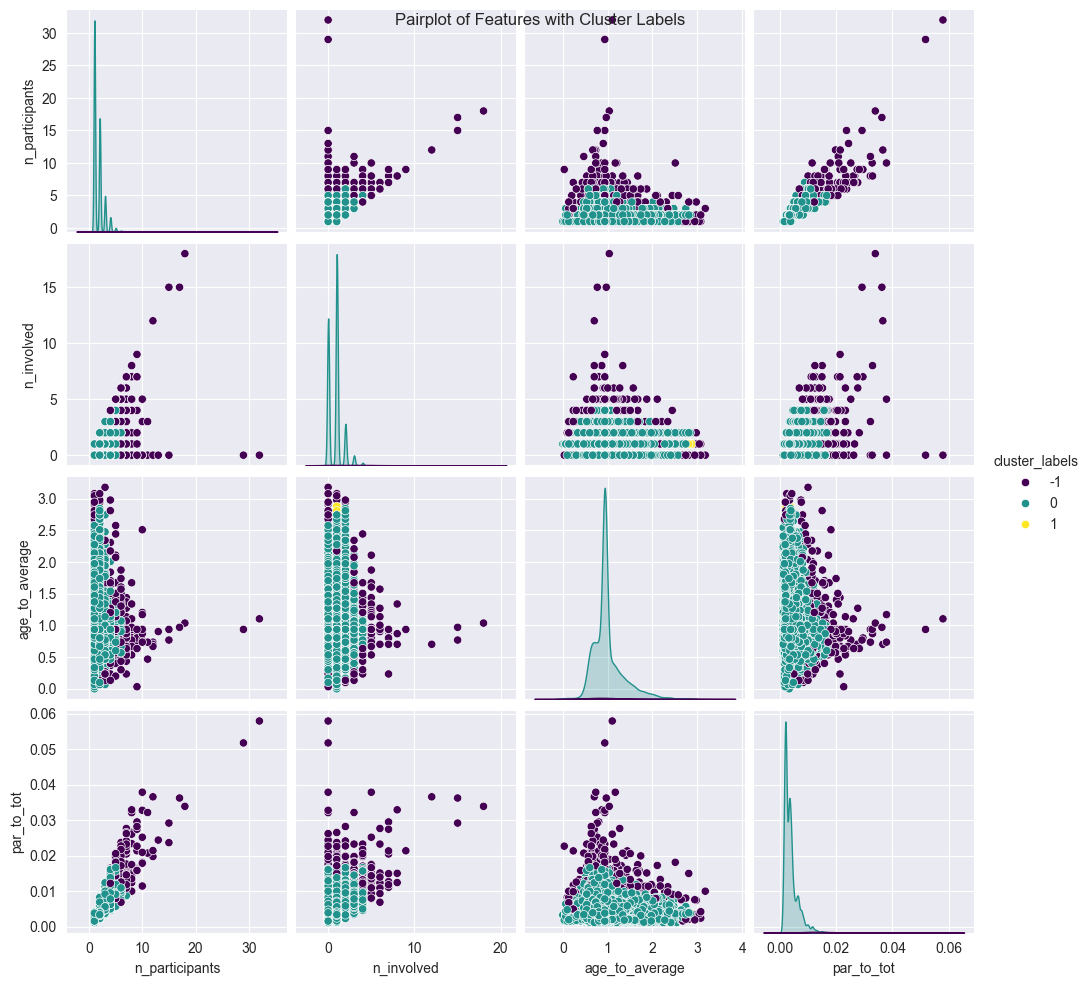

cluster_labels
 0    12785
-1      251
 1        6
Name: count, dtype: int64

In [40]:
dbscan = DBSCAN(eps=0.06, min_samples=21)
cluster_labels = dbscan.fit_predict(mm_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
print(silhouette_score(mm_scaled, cluster_labels))
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()

# Standard Scaling Test

In [41]:
ss_eps_values = np.linspace(0.1, 1.0, 10)

In [42]:
silhouette_scores = []
parameter_combinations = []

best_score = -1  # Initialize best silhouette score
best_params = {'eps': None, 'min_samples': None}

for eps in ss_eps_values:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(ss_scaled)

        unique_labels = np.unique(labels)
        if len(unique_labels) < 4 or len(unique_labels) > 50: continue
        silhouette = silhouette_score(ss_scaled, labels)
        print(
            f"Number of clusters: {len(unique_labels)}, eps: {eps}, min_samples: {min_sample} , Silhouette score: {silhouette}")
        silhouette_scores.append(silhouette)
        parameter_combinations.append((eps, min_sample, len(unique_labels)))

# Plotting the results
silhouette_scores = np.array(silhouette_scores)
parameter_combinations = np.array(parameter_combinations)

Number of clusters: 45, eps: 0.1, min_samples: 12 , Silhouette score: -0.11416649999723305
Number of clusters: 46, eps: 0.1, min_samples: 15 , Silhouette score: -0.14879278246493566
Number of clusters: 31, eps: 0.1, min_samples: 18 , Silhouette score: -0.12818564889417747
Number of clusters: 33, eps: 0.1, min_samples: 21 , Silhouette score: -0.16972573526616536
Number of clusters: 22, eps: 0.1, min_samples: 24 , Silhouette score: -0.10828792518363242
Number of clusters: 41, eps: 0.2, min_samples: 9 , Silhouette score: 0.08312913558821572
Number of clusters: 22, eps: 0.2, min_samples: 12 , Silhouette score: 0.13148833442948543
Number of clusters: 19, eps: 0.2, min_samples: 15 , Silhouette score: 0.14130734676722476
Number of clusters: 16, eps: 0.2, min_samples: 18 , Silhouette score: 0.12549305516744333
Number of clusters: 13, eps: 0.2, min_samples: 21 , Silhouette score: 0.13107719376860788
Number of clusters: 12, eps: 0.2, min_samples: 24 , Silhouette score: 0.1156985564804078
Number 

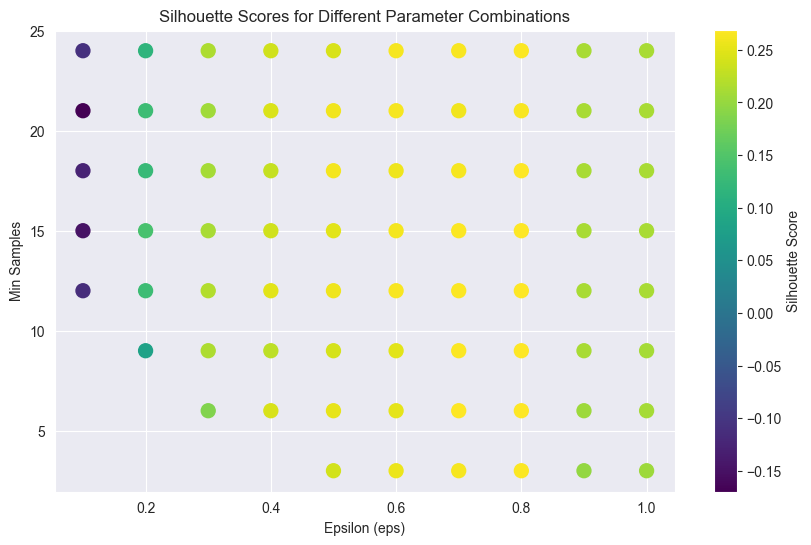

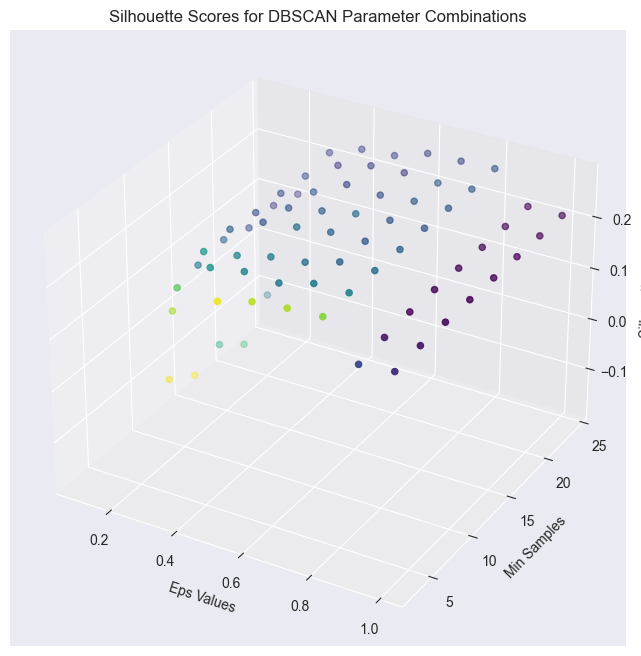

Best Silhouette Score: 0.2690237662237016
Best Parameters - eps: 0.8, min_samples: 9.0 Number of clusters: 21.0


In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(parameter_combinations[:, 0], parameter_combinations[:, 1], c=silhouette_scores, cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Min Samples')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.grid(True)
plt.show()

eps_values = parameter_combinations[:, 0]
min_samples_values = parameter_combinations[:, 1]
clusters = parameter_combinations[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(eps_values, min_samples_values, silhouette_scores, c=clusters, cmap='viridis')
ax.set_xlabel('Eps Values')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('Silhouette Scores for DBSCAN Parameter Combinations')

plt.show()

best_eps, best_min_samples = print_best_params(silhouette_scores, parameter_combinations)

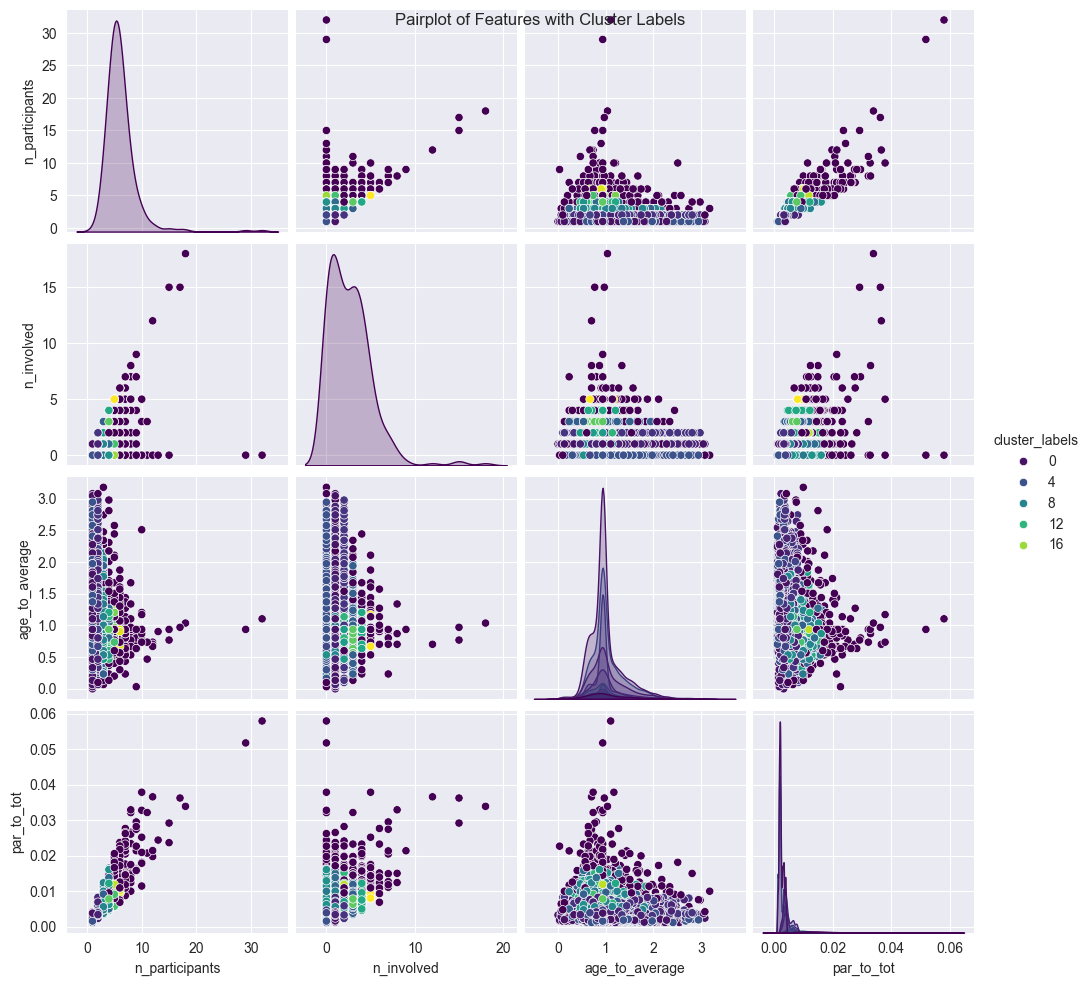

cluster_labels
 0     4241
 4     2883
 1     1672
 3     1250
 2      903
 8      439
-1      294
 10     262
 7      259
 5      245
 6      153
 9      119
 12     101
 11      74
 13      33
 16      32
 14      31
 15      18
 17      14
 18      10
 19       9
Name: count, dtype: int64

In [44]:
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
cluster_labels = dbscan.fit_predict(ss_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

0.2629552523190651


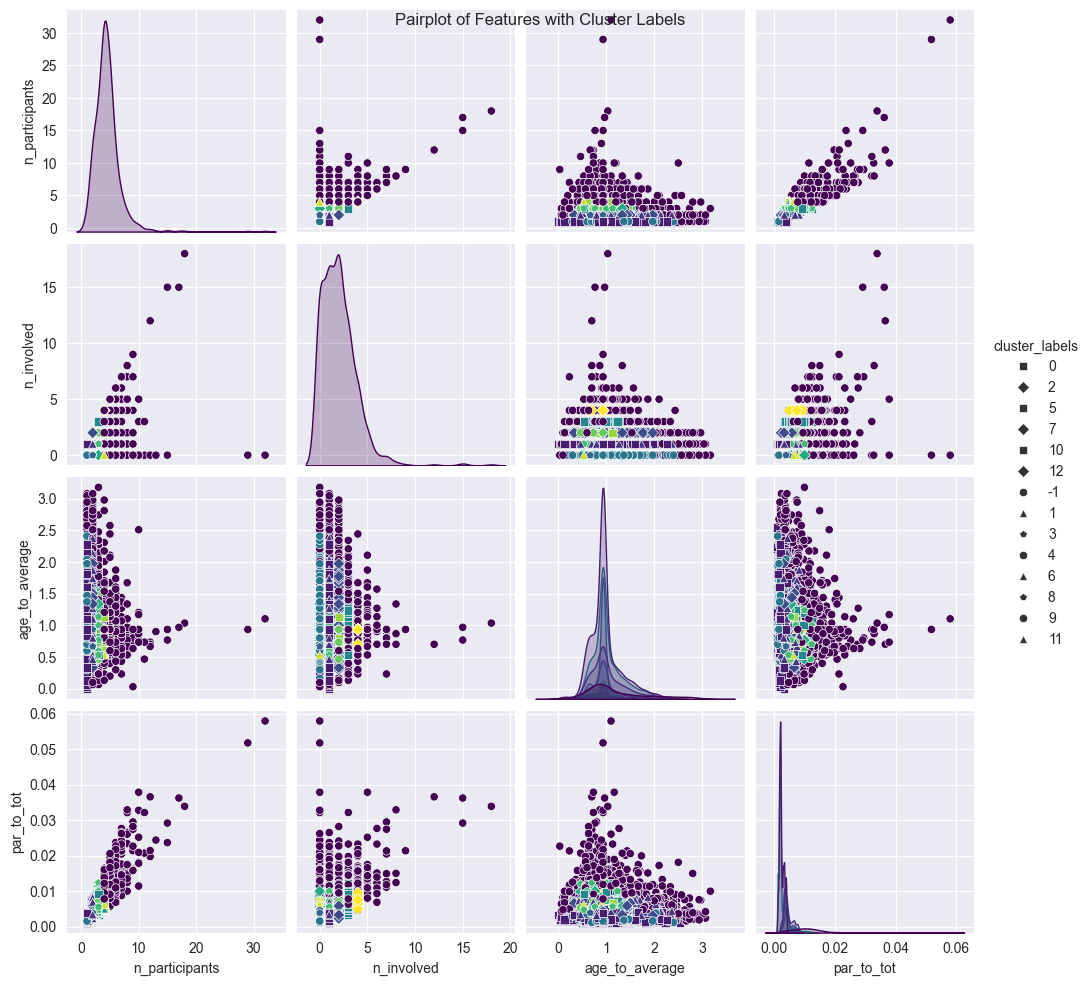

cluster_labels
 0     4231
 4     2875
 1     1653
 3     1228
 2      844
-1      825
 8      418
 7      254
 9      220
 5      213
 6      113
 11      77
 10      49
 12      42
Name: count, dtype: int64

In [45]:
dbscan = DBSCAN(eps=0.6, min_samples=24)
cluster_labels = dbscan.fit_predict(ss_scaled)
print(silhouette_score(ss_scaled, cluster_labels))
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis',
             markers=['o', 's', '^', 'D', 'p', 'o', 's', '^', 'D','p', 'o', 's', '^', 'D'])
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

0.21105851938358697


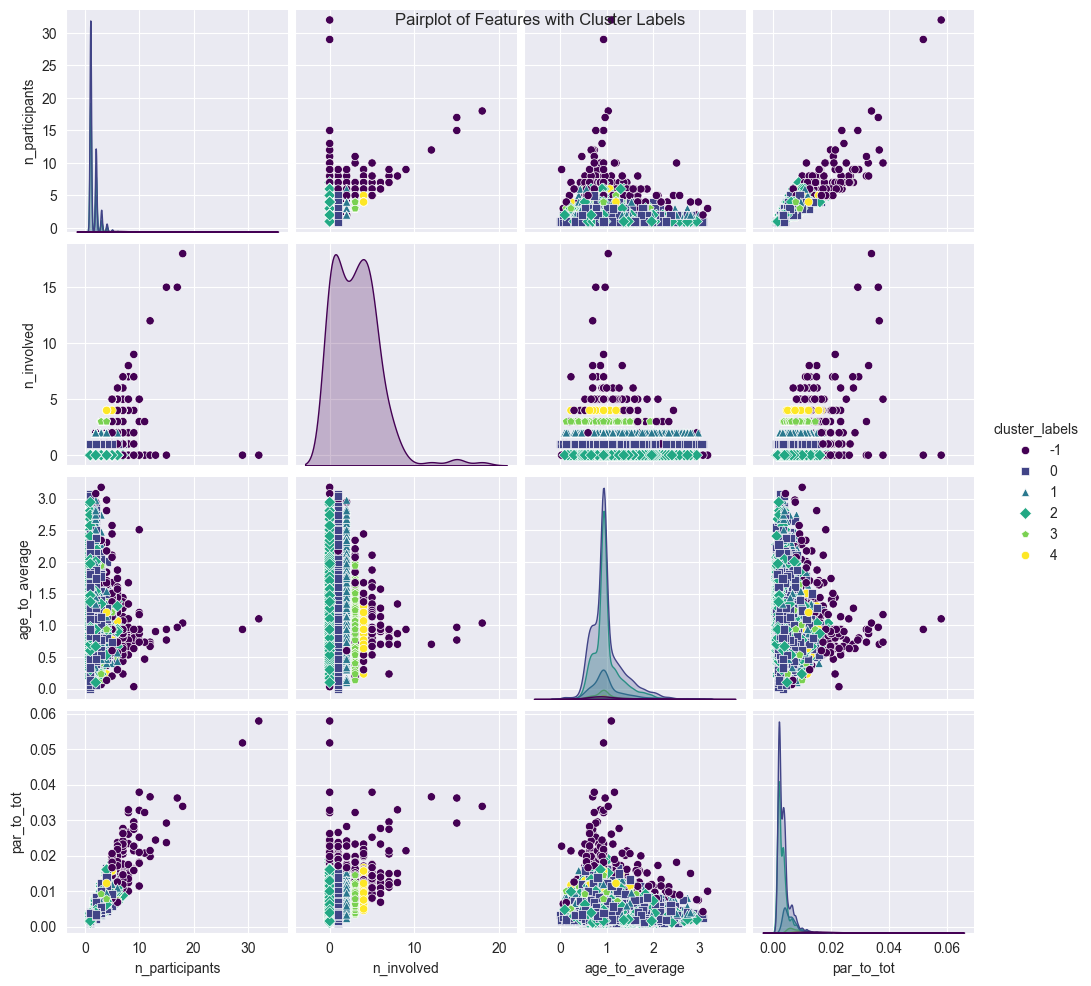

cluster_labels
 0    6568
 2    4569
 1    1296
 3     315
-1     205
 4      89
Name: count, dtype: int64

In [46]:
dbscan = DBSCAN(eps=1.0, min_samples=12)
cluster_labels = dbscan.fit_predict(ss_scaled)
print(silhouette_score(ss_scaled, cluster_labels))
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis',
             markers=['o', 's', '^', 'D', 'p', 'o'])
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

In [47]:
# print examples for each cluster
for i in selected_data['cluster_labels'].unique():
    print(f"Cluster {i}")
    print(selected_data[selected_data['cluster_labels'] == i].head())
    print("\n")

Cluster 0
     n_participants  n_involved  age_to_average  par_to_tot  cluster_labels
11                1           1        0.635322    0.001645               0
15                2           1        1.605025    0.006098               0
35                1           1        0.936265    0.001143               0
90                1           1        0.936265    0.001645               0
204               4           1        0.601884    0.008282               0


Cluster 1
     n_participants  n_involved  age_to_average  par_to_tot  cluster_labels
20                2           2        1.270645    0.006897               1
303               2           2        0.568446    0.004184               1
308               2           2        1.705339    0.003170               1
394               2           2        0.869389    0.003170               1
450               2           2        1.337521    0.004184               1


Cluster 2
    n_participants  n_involved  age_to_average  par_to

# Cluster Analysis

We choose the clustering on the last ss_scaled data with eps=0.6 and min_samples=12 as it's the one with more defined clusters and more balanced. The others had too many clusters or too few, and a lot of points were classified as noise.

Text(0.5, 1.0, 'Whole dataset')

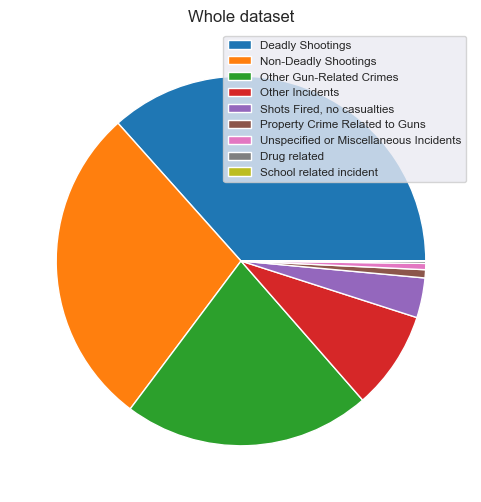

In [48]:
df['labels'] = cluster_labels
# pie plot of categories on the whole dataset

plt.figure(figsize=(6, 6))
plt.pie(df['incident_category'].value_counts())
plt.legend(labels=df['incident_category'].unique(), loc='upper right', fontsize = 'small')
plt.title("Whole dataset")

In [49]:
# merge label 3 and 4
df['labels'].replace(4, 3, inplace=True)
# Replace -1 (Noise label) with 5
df['labels'].replace(-1, 5, inplace=True)

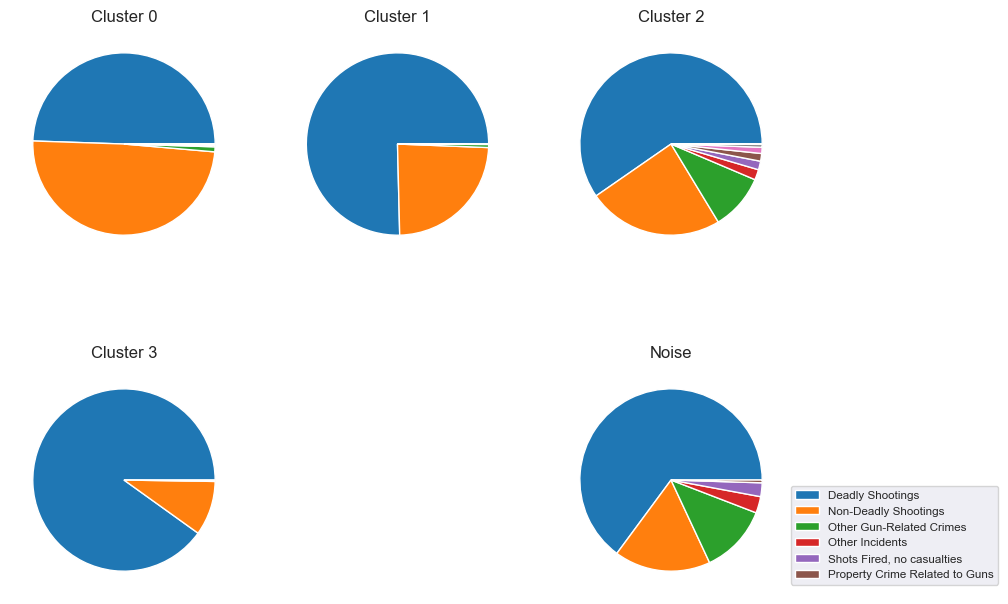

In [50]:
# for each label, pie plot of the category index
# Get unique labels from the 'labels' column
unique_labels = df['labels'].unique()

# Create subplots for each unique label
plt.figure(figsize=(10, 8))

for i in df['labels'].unique():
    plt.subplot(2, 3, i + 1)
    plt.pie(df[df['labels'] == i]['incident_category'].value_counts())
    if i == 5:
        plt.title("Noise")
        plt.legend(labels=df['incident_category'].unique(),bbox_to_anchor=(1, 0.5), fontsize = 'small')
    else:
        plt.title(f"Cluster {i}")

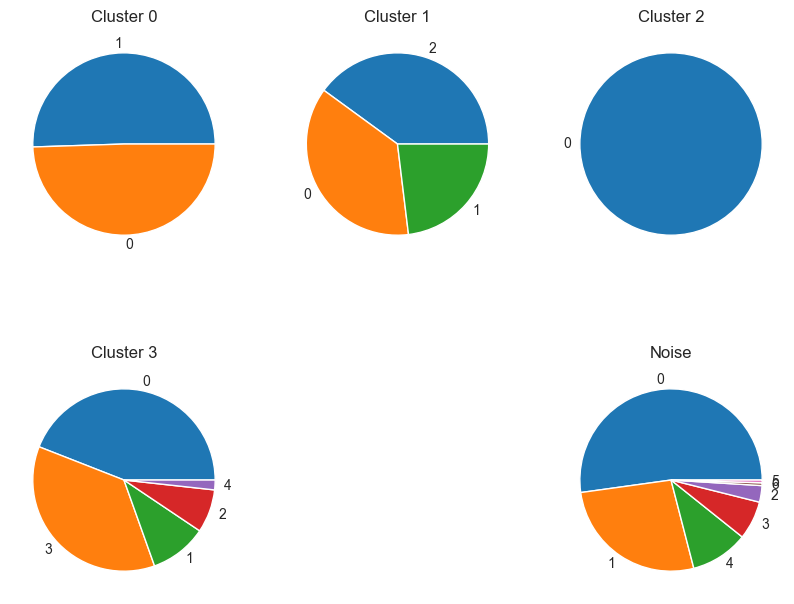

In [51]:
# for each label, pie plot of the number of people killed
plt.figure(figsize=(10, 8))
for i in df['labels'].unique():
    plt.subplot(2, 3, i + 1)
    plt.pie(df[df['labels'] == i]['n_killed'].value_counts(), labels=df[df['labels'] == i]['n_killed'].unique())
    if i == 5:
        plt.title("Noise")
    else:
        plt.title(f"Cluster {i}")

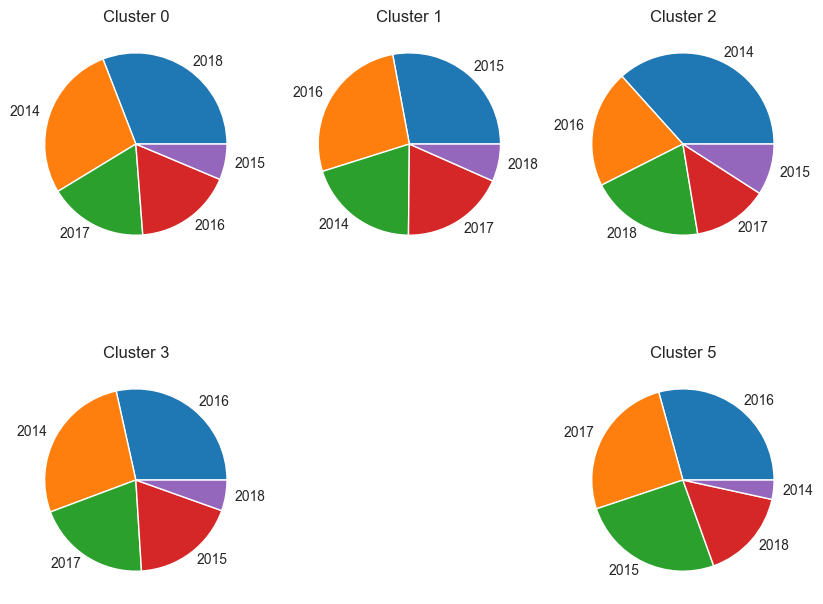

In [52]:
# for each label, pie plot of the year of the incident
plt.figure(figsize=(10, 8))
for i in df['labels'].unique():
    plt.subplot(2, 3, i + 1)
    plt.pie(df[df['labels'] == i]['year'].value_counts(), labels=df[df['labels'] == i]['year'].unique())
    plt.title(f"Cluster {i}")

In [53]:
# Group by 'labels' and apply specific describe for selected columns
summary = df[['man_to_p', 'fem_to_p', 'n_minors', 'n_arrested', 'labels']].groupby('labels').describe()

# Select specific statistics (max, min, mean) for each column
summary = summary[[
    ('man_to_p', 'max'), ('man_to_p', 'min'), ('man_to_p', 'mean'),
    ('fem_to_p', 'max'), ('fem_to_p', 'min'), ('fem_to_p', 'mean'),
    ('n_minors', 'max'), ('n_minors', 'min'), ('n_minors', 'mean'),
    ('n_arrested', 'max'), ('n_arrested', 'min'), ('n_arrested', 'mean')
]]

summary

man_to_p                     fem_to_p                n_minors       \
            max       min      mean      max  min      mean      max  min   
labels                                                                      
0           1.0  0.000000  0.894020     1.00  0.0  0.081607      4.0  0.0   
1           1.0  0.000000  0.773966     1.00  0.0  0.178073      5.0  0.0   
2           1.0  0.000000  0.937369     1.00  0.0  0.048272      4.0  0.0   
3           1.0  0.000000  0.738229     0.75  0.0  0.173244      4.0  0.0   
5           1.0  0.111111  0.741314     0.80  0.0  0.155264     11.0  0.0   

                 n_arrested                 
            mean        max  min      mean  
labels                                      
0       0.110283        5.0  0.0  0.234166  
1       0.193851        4.0  0.0  0.195988  
2       0.102667        7.0  0.0  0.866710  
3       0.367816        3.0  0.0  0.153465  
5       0.723404       31.0  0.0  1.990244